# Introduction: Bias in EHR Data and Its Impact on AI Models

This notebook explores how biases within Electronic Health Records (EHR) data -such as differences in disease prevalence across gender, ethnicity, and age- can impact the performance and outcomes of AI models in healthcare. Our analysis investigates how underlying demographic disparities influence model predictions and may contribute to healthcare inequities.

We begin by visualizing these demographic patterns in our dataset, then consider their implications for AI model development and evaluation.

## Import Libraries

In [8]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# 📊 Basic Visualizations

In [9]:
# Data loading

df = pd.read_csv("./data/training_v2.csv")
keys = pd.read_csv("./data/WiDS_Datathon_2020_Dictionary.csv")

In [10]:
def bucket_plot(df, x_col, y_col, num_buckets=10, xlabel=None, ylabel=None, title="Bucket Scatter Plot"):
    df = df.copy()
    df["xcol"] = df.eval(x_col)
    df["ycol"] = df.eval(y_col)
    df = df[["xcol", "ycol"]].dropna()
    df["bucket"], edges = pd.cut(df["xcol"], bins=num_buckets, retbins=True, labels=False)
    
    bucket_stats = df.groupby("bucket").agg(
        mean_x=("xcol", "mean"),
        mean_y=("ycol", "mean")
    ).dropna()
    
    plt.scatter(bucket_stats["mean_x"], bucket_stats["mean_y"], color='b', edgecolors='black', alpha=0.7)
    
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.title(title)
    
    plt.show()

## Age Distribution:

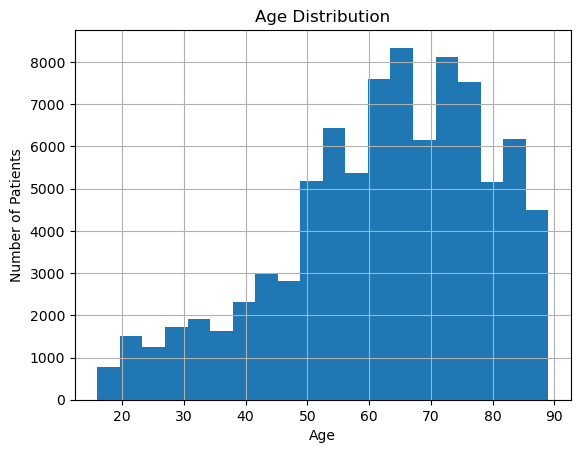

In [11]:
# Age distribution
df['age'].hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Age Distribution')
plt.show()

## Gender Distribution:

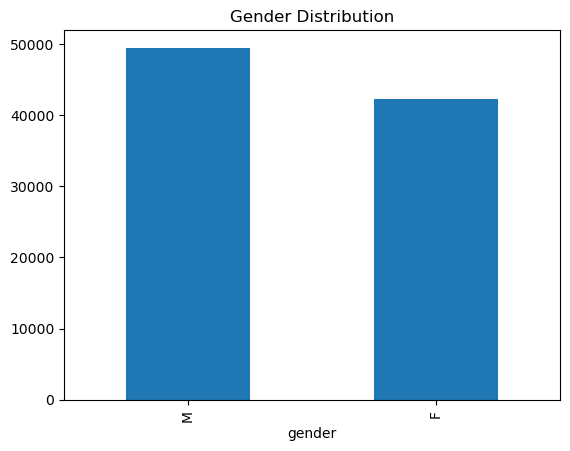

In [12]:
# Gender distribution
plt.figure()
df['gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.show()

In [13]:
print(df.eval("gender == 'M'").sum())
print(df.eval("gender == 'F'").sum())

49469
42219


In [14]:
print("Male percentage:", df.eval("gender == 'M'").mean())
print("Female percentage:", df.eval("gender == 'F'").mean())

Male percentage: 0.5393891814682761
Female percentage: 0.460338229040594


## Disease Prevalence by Gender

In [15]:
# Disease prevalence by gender
diseases = ['leukemia', 'hepatic_failure', 'immunosuppression', 'lymphoma', 'cirrhosis', 'aids']
results = {}
for disease in diseases:
    t_stat, p_val = ttest_ind(
        df.query("gender == 'M'")[disease], 
        df.query("gender == 'F'")[disease], 
        equal_var=False, 
        nan_policy='omit'
    )
    results[disease] = {'tstat M = F': t_stat}

pd.concat([
    df.groupby('gender')[diseases].mean(), 
    pd.DataFrame(results)
])

,leukemia,hepatic_failure,immunosuppression,lymphoma,cirrhosis,aids
F,0.005946,0.010698,0.026745,0.003868,0.012776,0.000406
M,0.008025,0.014950,0.025684,0.004359,0.018189,0.001242
tstat M = F,3.775242,5.719781,-0.997168,1.154392,6.638639,4.473519


<Figure size 640x480 with 0 Axes>

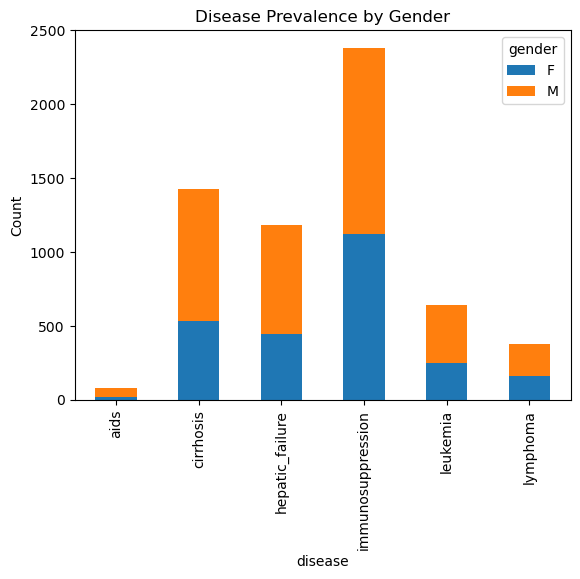

In [16]:
# Disease prevalence by gender
plt.figure()
df_disease = df[['gender'] + diseases].copy()
df_disease = df_disease.melt(id_vars='gender', var_name='disease', value_name='presence')
df_disease = df_disease[df_disease['presence'] == 1]
df_disease.groupby(['disease', 'gender']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Disease Prevalence by Gender')
plt.ylabel('Count')
plt.show()

In [17]:
# Total number of disease presence occurrences (across all diseases and genders)
total_disease_occurrences = df[diseases].sum().sum()
print(total_disease_occurrences)

6088.0


## Disease Prevalence by Ethnicity

In [18]:
# Calculate Proportion of Encounters per Ethnicity
df.groupby('ethnicity').encounter_id.count() / len(df)

ethnicity
African American    0.104096
Asian               0.012310
Caucasian           0.770709
Hispanic            0.041390
Native American     0.008592
Other/Unknown       0.047692
Name: encounter_id, dtype: float64

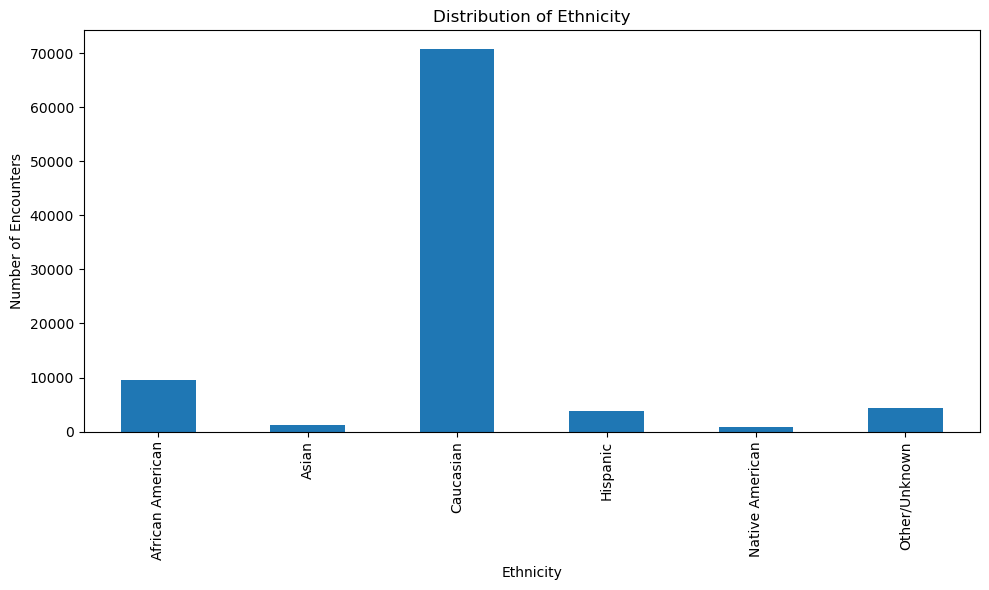

In [19]:
ethnicity = df.groupby('ethnicity').encounter_id.count()
ethnicity.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Encounters')
plt.tight_layout()
plt.show()

In [20]:
# Calculate Mean Prevalence of Diseases by Ethnicity
df.groupby('ethnicity')[diseases].mean() 

,leukemia,hepatic_failure,immunosuppression,lymphoma,cirrhosis,aids
ethnicity,,,,,,
African American,0.006025,0.008139,0.023888,0.002220,0.008879,0.002960
Asian,0.005329,0.014210,0.024867,0.005329,0.015986,0.000000
Caucasian,0.007443,0.012661,0.027362,0.004591,0.015114,0.000570
Hispanic,0.007443,0.020734,0.021531,0.001861,0.025518,0.000797
Native American,0.006394,0.070332,0.025575,0.003836,0.081841,0.001279
Other/Unknown,0.004834,0.014733,0.021639,0.003453,0.023020,0.001381


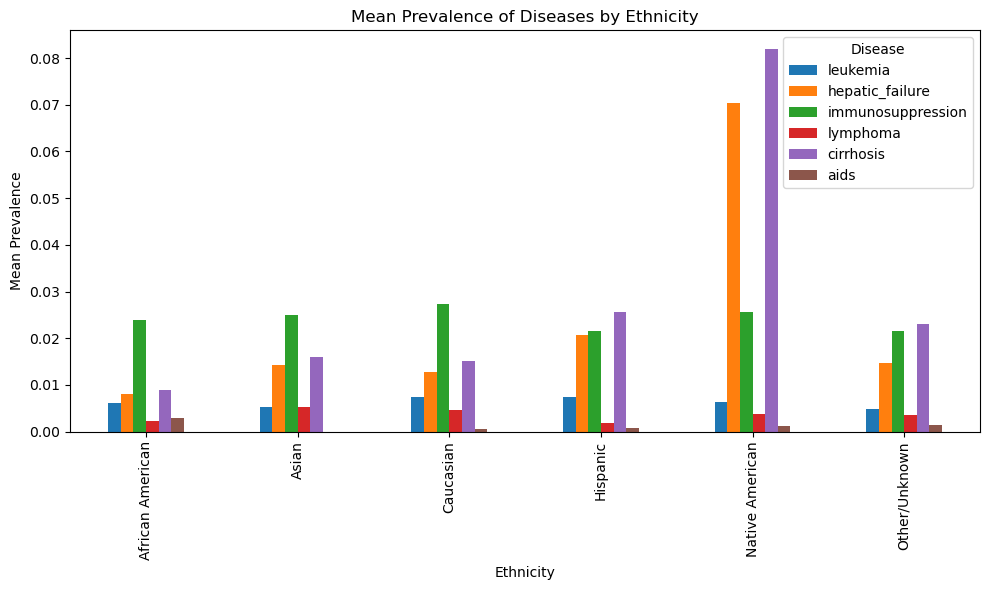

In [21]:
# Visualize Disease Prevalence by Ethnicity
disease_by_ethnicity = df.groupby('ethnicity')[diseases].mean()
disease_by_ethnicity.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Prevalence of Diseases by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Mean Prevalence')
plt.legend(title='Disease')
plt.tight_layout()
plt.show()

## 🔍 Findings: 
- __Mean age is 62__, left skewed. Younger people is underrepresented.
- __Similar number of male and female__
    - __Men are likely to have disease__.
    - The difference is significant in cirrhosis, hepatic failure, aids, and leukemia
        - Guess: __cirrhosis because men drink more__, __aids because gays are categorized as men__
- __77% of patients are white__.
    - Caucasian vs Native American shows sign. difference
    - Caucasian vs African American shows notable difference.

# Modelling

## Try throwing data in
Exploring Connections Between Cirrhosis and Patient Characteristics

In [22]:
labs = ["d1_bilirubin_max", "d1_bilirubin_min", "d1_albumin_max", "d1_albumin_min"]

### Albumin Levels

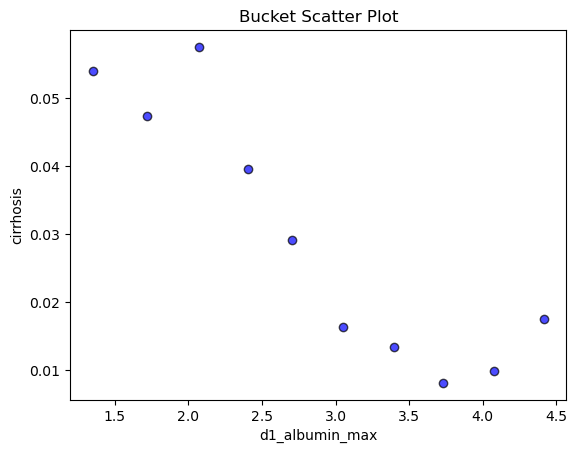

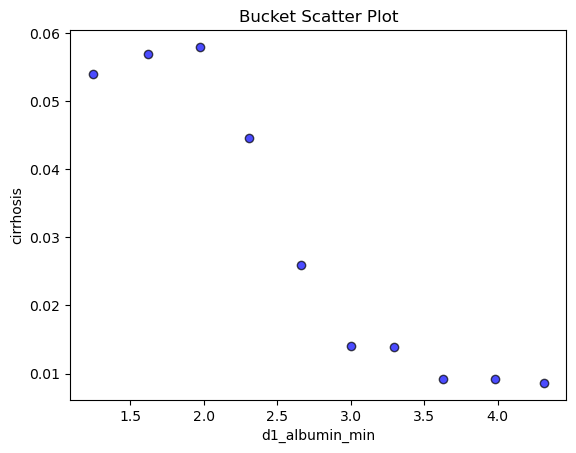

In [23]:
# Albumin & Cirrhosis Analysis
bucket_plot(df, "d1_albumin_max", "cirrhosis")
bucket_plot(df, "d1_albumin_min", "cirrhosis")

Both __maximum__ and __minimum__ albumin levels showed a clear association with cirrhosis. Lower albumin levels often coincided with higher cirrhosis prevalence.

### Bilirubin Levels:

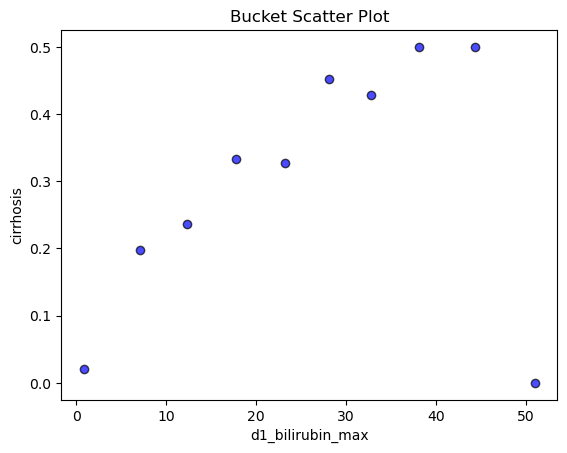

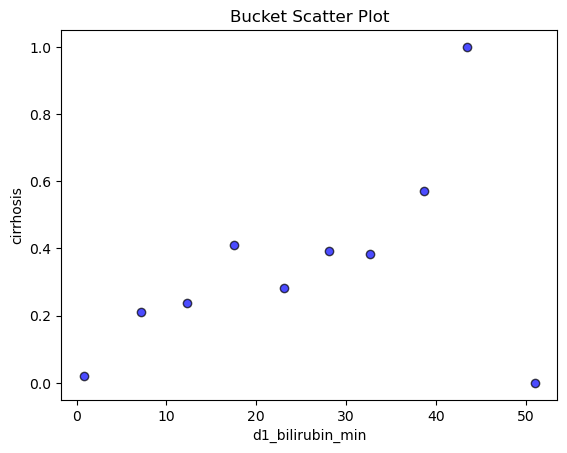

In [24]:
# Bilirubin & Cirrhosis Analysis
bucket_plot(df, "d1_bilirubin_max", "cirrhosis")
bucket_plot(df, "d1_bilirubin_min", "cirrhosis")

Similarly, patients with __higher bilirubin max and min levels__ tended to have an increased likelihood of cirrhosis, reflecting the liver's impaired function.

### Age:

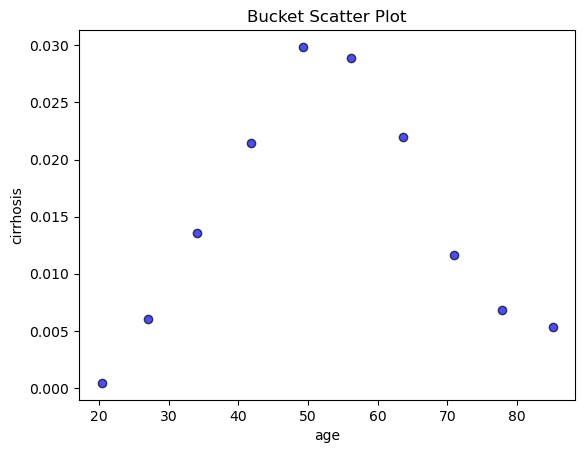

In [25]:
# Age & Cirrhosis Prevalence
bucket_plot(df, "age", "cirrhosis")

The incidence of cirrhosis also increases with age, highlighting its severe impact on elderly patients aged 50-60 years.

### Define model

In [26]:
def train_model (df) :
    features = [
        'd1_albumin_max', 'd1_albumin_min',
        'd1_inr_max','d1_inr_min',
        'd1_bilirubin_max', 'd1_bilirubin_min',
        'd1_platelets_min',
        'map_apache', 'd1_mbp_min',
        'creatinine_apache', 'd1_creatinine_max',
        'urineoutput_apache', 
        'bun_apache',
        'd1_sodium_min', 'd1_potassium_max',
        'd1_temp_max', 'd1_temp_min',
        'd1_wbc_max', 'd1_wbc_min',
        'd1_lactate_max'
    ]
    
    groups = ["gender", "age", "ethnicity"]
    
    target = 'cirrhosis'
    df = df.dropna(subset=[target])
    
    X = df[features + groups]
    y = df[[target] + groups]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    model.fit(X_train[features], y_train[target])

    return model, (X_test, y_test)

def print_classification_report (model, validation_set, group = "index == index") : 
    X_test, y_test = validation_set
    y_pred = model.predict(X_test.query(group)[features])
    print("\nClassification Report:")
    print(classification_report(y_test.query(group)[target], y_pred))

def print_confusion_matrix (model, validation_set, group = "index == index") :
    X_test, y_test = validation_set
    y_pred = model.predict(X_test.query(group)[features])
    cm = confusion_matrix(y_test.query(group)[target], y_pred)
    n = len(y_test.query(group))

    print("Confusion Matrix (Proportions):")
    print(f"              Predicted 0     Predicted 1")
    print(f"Actual 0      {cm[0][0] / n * 100:.2f} %          {cm[0][1] / n * 100:.2f} %")
    print(f"Actual 1      {cm[1][0] / n * 100:.2f} %          {cm[1][1] / n * 100:.2f} %")

features = [
    'd1_albumin_max', 'd1_albumin_min',
    'd1_inr_max','d1_inr_min',
    'd1_bilirubin_max', 'd1_bilirubin_min',
    'd1_platelets_min',
    'map_apache', 'd1_mbp_min',
    'creatinine_apache', 'd1_creatinine_max',
    'urineoutput_apache', 
    'bun_apache',
    'd1_sodium_min', 'd1_potassium_max',
    'd1_temp_max', 'd1_temp_min',
    'd1_wbc_max', 'd1_wbc_min',
    'd1_lactate_max']
target = 'cirrhosis'

In [27]:
# Training
model, validation_set = train_model(df)

In [28]:
print_classification_report (model, validation_set)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     26836
         1.0       0.57      0.03      0.05       464

    accuracy                           0.98     27300
   macro avg       0.78      0.51      0.52     27300
weighted avg       0.98      0.98      0.98     27300



We have accuracy of 98%!!!

That comes with 57% precision, 3% recall. i.e. of all cases model say has cirrhosis, only 57% has, and out of all cirrhosis cases, the model found 3%. Not ideal. Let's see the report on each of the groups.

In [29]:
print_classification_report (model, validation_set, "gender == 'M'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     14487
         1.0       0.62      0.03      0.05       294

    accuracy                           0.98     14781
   macro avg       0.80      0.51      0.52     14781
weighted avg       0.97      0.98      0.97     14781



In [30]:
print_classification_report (model, validation_set, "gender == 'F'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12342
         1.0       0.50      0.02      0.04       170

    accuracy                           0.99     12512
   macro avg       0.74      0.51      0.52     12512
weighted avg       0.98      0.99      0.98     12512



The model performs worse on Female!

In [31]:
print_classification_report (model, validation_set, "ethnicity == 'Native American'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       222
         1.0       0.80      0.27      0.40        15

    accuracy                           0.95       237
   macro avg       0.88      0.63      0.69       237
weighted avg       0.94      0.95      0.94       237



In [32]:
warnings.filterwarnings('ignore')
print_classification_report (model, validation_set, "ethnicity == 'African American'") 


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2828
         1.0       0.00      0.00      0.00        27

    accuracy                           0.99      2855
   macro avg       0.50      0.50      0.50      2855
weighted avg       0.98      0.99      0.99      2855



In [33]:
print_classification_report (model, validation_set, "ethnicity == 'Caucasian'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     20666
         1.0       0.50      0.02      0.04       348

    accuracy                           0.98     21014
   macro avg       0.74      0.51      0.52     21014
weighted avg       0.98      0.98      0.98     21014



> The model simply says __"no cirrhosis"__ to __black patients!__


> All of this while the __model did not actually know the ethnicity of the patient__. The model __only get the lab and vital data__.

## 🛠 Fixing Precision & Recall

One problem with the last model where we just throw data in is that the model optimizes for accuracy, but we don't really want accuracy. __Simply say no already gives us 97%__. What we __might want from this diagnosis model is recall and precision__. Out of all patients with disease, we __want model to say positive as many as possible (recall) but we also don't want the model to say yes all the time__, so out of all that they say yes, we want a lot to be actually positive. (precision)

In [34]:
df_size = 3000 # set a target sample size

positive = df[df['cirrhosis'] == 1]
negative = df[df['cirrhosis'] == 0]

positive_sampled = positive.sample(n=df_size, replace=True, random_state=42) # sampling with replacement (since there might not be enough real cirrhosis cases, this allows duplicate rows)
negative_sampled = negative.sample(n=df_size, replace=False, random_state=42) # sampling without replacement (because we probably have enough negative examples to avoid duplicates)

df_balanced = pd.concat([negative_sampled, positive_sampled], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [35]:
print("The number of original Dataframe:", len(df))
print("The number of rebalanced Dataframe:", len(df_balanced))

The number of original Dataframe: 91713
The number of rebalanced Dataframe: 6000


From the __total 90k records__, we __rebalanced__ the dataframe __to only include 6k__ with equal cases and non-cases of cirrhosis. 

>__Now, the model can't just say no, right?__

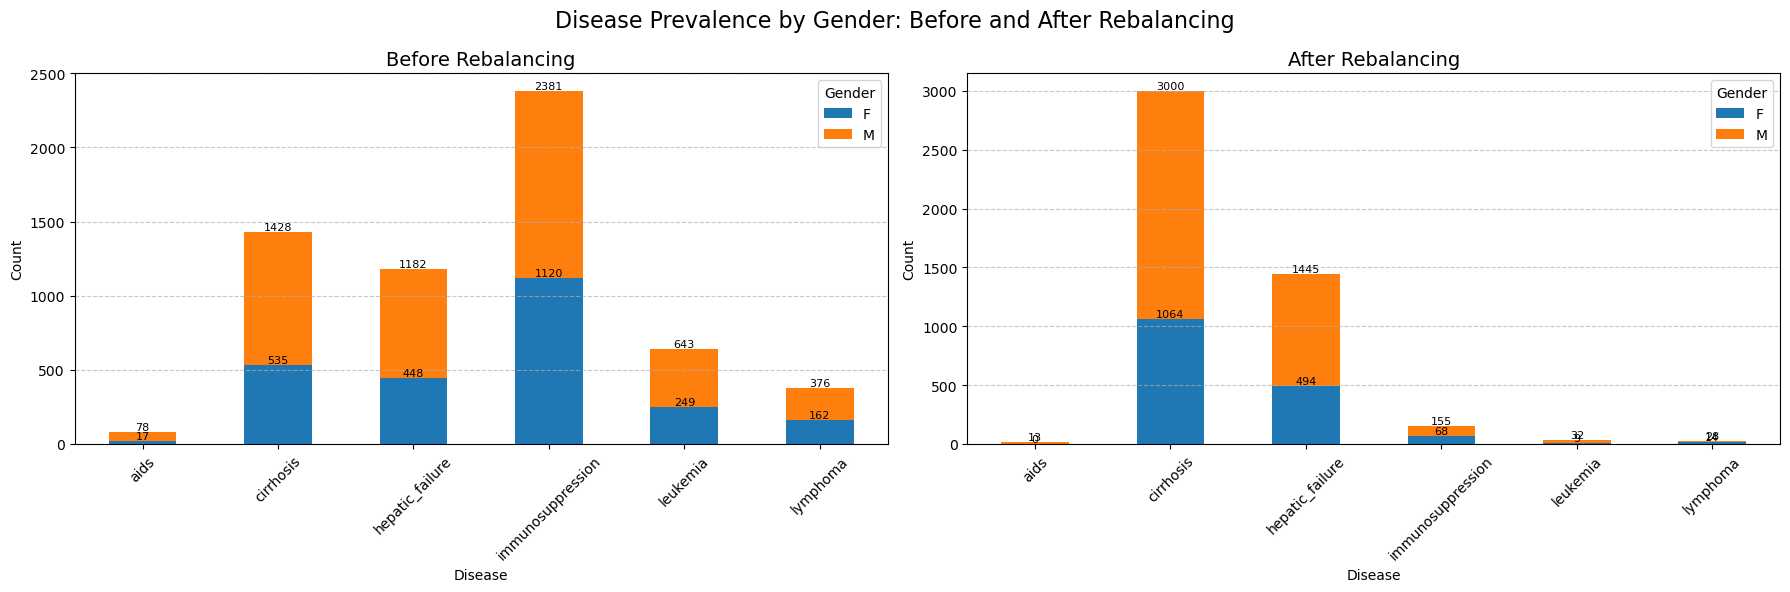

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

def plot_disease_prevalence(ax, df, title):
    df_disease = df[['gender'] + diseases].copy()
    df_disease = df_disease.melt(id_vars='gender', var_name='disease', value_name='presence')
    df_disease = df_disease[df_disease['presence'] == 1]
    
    counts = df_disease.groupby(['disease', 'gender']).size().unstack(fill_value=0)
    counts.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e'])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Disease')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='Gender', loc='upper right')
    ax.tick_params(axis='x', rotation=45)

# Before rebalancing plot
plot_disease_prevalence(axs[0], df, 'Before Rebalancing')

# After rebalancing plot
plot_disease_prevalence(axs[1], df_balanced, 'After Rebalancing')

# Set overall title
fig.suptitle('Disease Prevalence by Gender: Before and After Rebalancing', fontsize=16)

plt.tight_layout()
plt.show()

In [37]:
### Check If gender balance?
print('The number of male cohort', len(df_balanced.query("gender == 'M'")))
print('The number of male cohorts with cirrhosis', len(df_balanced.query("gender == 'M' and cirrhosis == 1")))

The number of male cohort 3588
The number of male cohorts with cirrhosis 1936


In [38]:
print('The number of female cohort', len(df_balanced.query("gender == 'F'")))
print('The number of female cohorts with cirrhosis', len(df_balanced.query("gender == 'F' and cirrhosis == 1")))

The number of female cohort 2412
The number of female cohorts with cirrhosis 1064


In [39]:
# Training
model, validation_set = train_model(df_balanced)

In [40]:
print_classification_report (model, validation_set)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       913
         1.0       0.89      0.91      0.90       887

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



In [41]:
print_confusion_matrix (model, validation_set, "gender == 'M'")

Confusion Matrix (Proportions):
              Predicted 0     Predicted 1
Actual 0      40.55 %          5.84 %
Actual 1      5.02 %          48.58 %


In [42]:
print_confusion_matrix (model, validation_set, "gender == 'F'")

Confusion Matrix (Proportions):
              Predicted 0     Predicted 1
Actual 0      52.20 %          5.25 %
Actual 1      3.26 %          39.29 %


The model predicted false more often for women. It actually also wrong less often. This fits with the reality where women empirically don't have cirrhosis. Is this a good thing? 
- the model has high accuracy, precision, and recall
- it seems that it capture the reality well.
- what if the next patient is a heavy drinker women ? 

# What do we think about fake data?
- On one hand, we can create a dataset where there is a column `drinker`. We can then demonstrate that the model biased toward men being drinker, thus higher likelihood of cirrhosis.
- On the other hand, the data is fake. That is bad in itself (?)

I'm on the side supporting fake (but sensible) dataset where we only add the column drinker in this one. Then, we show that the fixed model still bias (not on saying no all the time) but on make being drinker. Then, we show yet another balanced dataset. 

Of course, this might just be enough already. Of course, other ideas are more than welcome!

# Appendix: Key Concepts for Interpreting AI Results in Healthcare

1. Understanding the Classification Report
* __Precision__

    * Definition: The proportion of positive identifications that were actually correct.
    * Formula:
        $$
        \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
        $$
    * Example: If your __model predicted 100__ patients will recover and __80 of them actually did__, __precision = 80%__.


* __Recall (Sensitivity)__ 

    * Definition: The proportion of actual positives that were identified correctly.
    * Formula:
        $$
        \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
        $$
    * Example: If __100 patients actually recovered__ and the __model identified 80__ of them, __recall = 80%__.

* __F1-score__ 
    * Definition: A single score that balances precision and recall (their harmonic mean).
    * Good for: Imbalanced datasets where both false positives and false negatives matter.
    * Formula:
        $$
        \text{F1} = 2*\frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}
        $$    


* __Support__: The number of true instances for each label in the dataset.


2. __Common AI Evaluation Metrics in Healthcare__
* __AUC-ROC__: 
    Measures a model’s ability to distinguish between classes (disease vs. no disease) at various thresholds.

* __Confusion Matrix__: 
    Summarizes the number of correct and incorrect predictions.
    Example: True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN).

* __Accuracy__: 
    Overall percentage of correct predictions.
    Caution: Can be misleading if classes are imbalanced.